# Transfer learning with a pre-trained neural network

The task at hand was to correctly classify 664 images from into 4 categories:

1. Trees and forests
2. Rivers
3. Sunsets
4. Cloudy skies

During the competition (an in class competition for our machine learning class), only traditional computer vision techniques were allowed. However, I thought it would be interesting to apply a deep learning approach. However, it wasn't feasible to build something from scratch because we only had roughly ~180 images to train on per category. 

In such a scenario, it is possible to use transfer learning. Since I had a small number of pictures, and they were similar to the images that the model (ResNet50) was trained on, I decided to freeze all the original layers and just add one dense layer and a classification layer on top of the original network. I also took advantage of image augmentation using Keras's ImageDataGenerator class. This also helped me to train for more epochs without overfitting. 

Much of the code comes from François Chollet's excellent book ***Deep Learning with Python***. This notebook was made with Google Colaboratory which gives access to Nvidia's K80 GPU.

More details can be found in the in class competition page: https://www.kaggle.com/c/bda-2018-scene-recognition

### Connecting to my GDrive where the images are stored




In [0]:
# Mount my GDrive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os

# Set working directory
os.chdir('drive/My Drive/images_split')

train_dir = 'train'
validation_dir = 'validation'
test_dir = 'test'

### Loading the model and adding layers

In this step, the ResNet50 model is loaded with weights from ImageNet. However, we remove the final classification layer from the model. We assign this as the base layer, freeze all the layers, and add our own dense layer and classification layer on top.

In [0]:
from keras import models
from keras import layers
from keras.applications import ResNet50

# ResNet50 model with preloaded ImageNet weights
resnet_base = ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3),
                       pooling = 'avg')

# Create new dense layers on top of conv base
ResNet50_model = models.Sequential()
ResNet50_model.add(resnet_base)
ResNet50_model.add(layers.Dense(256, activation='relu'))
ResNet50_model.add(layers.Dense(4, activation='softmax'))

# Freeze the base layer
ResNet50_model.layers[0].trainable = False

# Get model summary
ResNet50_model.summary()

Using TensorFlow backend.


94658560/94653016 [==============================] - 8s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 24,113,284
Trainable params: 525,572
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
from keras import optimizers

# Compiling the model
ResNet50_model.compile(loss='categorical_crossentropy',
                       optimizer=optimizers.RMSprop(lr=2e-5),
                       metrics=['acc'])

### Setting up generators

One advantage of using generators is that images are loaded in batches every iteration. This is really helpful especially when there are a lot of images and they can't all be loaded into memory at once. Note that we only set the image augmentation settings for the training data generator. This is because we want to validate against the **original** images rather than digitally altered image.

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

# Augmentation settings below
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

# Validation data is not augmented
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Creating the train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=30,
    class_mode='categorical')

# Creating the validation generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=40,
    class_mode='categorical')

Found 584 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


### Showing the images

In case you were curious what the original images look like and what the augmented images look like.

#### Original images:

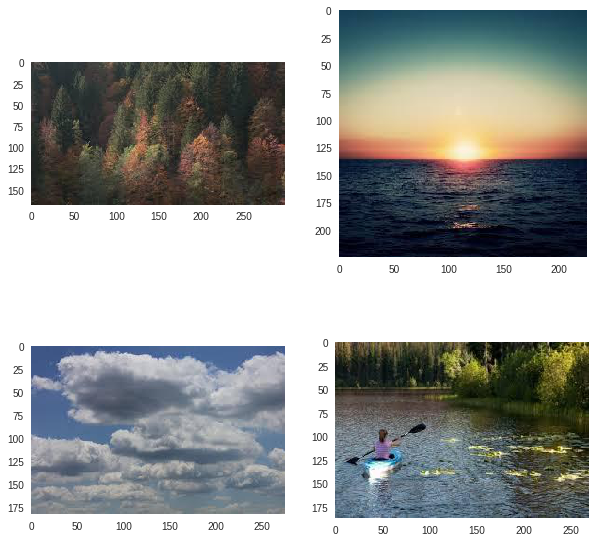

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Image categories and the path to 1 random image per category
image_categories = ['trees_and_forest', 'sunsets', 'cloudy_sky', 'rivers']
images = [os.path.join('train/{}'.format(each), 
                       np.random.choice(os.listdir('train/{}'.format(each)))) for each in image_categories]

# Create the figure and show the images
fig = plt.figure(figsize = (10,10))

for i in range(len(images)):
  ax = fig.add_subplot(2,2,i+1)
  plt.imshow(image.load_img(images[i]))
  plt.grid(None)

#### Augmented images:

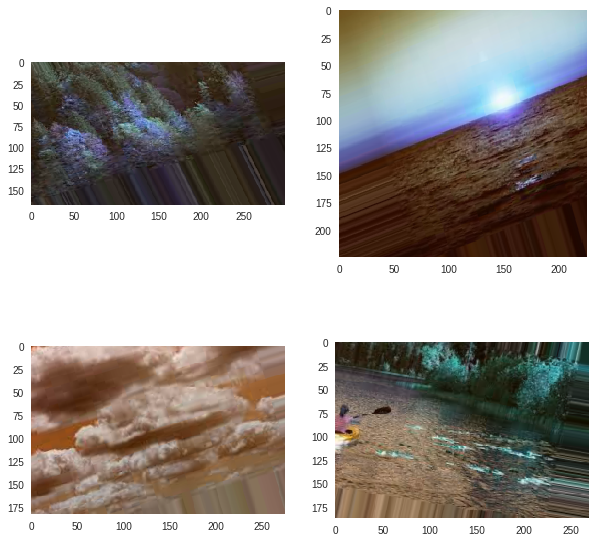

In [0]:
from keras.preprocessing.image import img_to_array, array_to_img

img_list = []

# Iteratively augment all the images we selected earlier
for current_img in images:
    # Load the image 
    img = image.load_img(current_img)  
    x = img_to_array(img) 
    x = x.reshape((1,) + x.shape) 
    
    # Start counter and generator 
    i = 0
    for batch in train_datagen.flow(x, batch_size=1):
      img_list.append(batch[0,:,:,:])
      i += 1
      if i >= 1:
        break   
        
# Create the figure and show the images
fig = plt.figure(figsize = (10,10))

for i in range(len(img_list)):
  ax = fig.add_subplot(2,2,i+1)
  plt.imshow(array_to_img(img_list[i]))
  plt.grid(None)

### Training the model

I set a maximum of 500 epochs. Realistically, that will probably result in overfitting. I defined an early stopper - i.e. once the validation loss does not fall by a set threshold for more than 10 epochs, the model stops training. The best models (according to validation loss at the time of training) are also saved to be used for prediction later.

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Make file
os.mkdir('ResNet_models')

# Define Callback - early stopping defined based on validation loss
callbacks = [EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01),
             ModelCheckpoint('ResNet_models/ResNet_Transfer-{epoch:02d}-{val_loss:.2f}.h5', 
                             verbose=0, 
                             monitor='val_loss',
                             save_best_only=True,
                             mode='auto')]

# Fitting the model
history = ResNet50_model.fit_generator(
    train_generator,
    steps_per_epoch=19,
    callbacks=callbacks,
    epochs=500,
    validation_data=validation_generator,
    validation_steps=2)

Epoch 1/500
19/19 [==============================] - 364s 19s/step - loss: 1.4012 - acc: 0.3754 - val_loss: 1.0181 - val_acc: 0.6375
Epoch 2/500
19/19 [==============================] - 15s 798ms/step - loss: 1.0759 - acc: 0.5580 - val_loss: 0.8221 - val_acc: 0.7250
Epoch 3/500
19/19 [==============================] - 10s 509ms/step - loss: 0.8747 - acc: 0.7130 - val_loss: 0.6795 - val_acc: 0.8375
Epoch 4/500
19/19 [==============================] - 9s 500ms/step - loss: 0.7137 - acc: 0.8100 - val_loss: 0.5709 - val_acc: 0.8750
Epoch 5/500
19/19 [==============================] - 10s 510ms/step - loss: 0.6495 - acc: 0.7980 - val_loss: 0.5073 - val_acc: 0.8875
Epoch 6/500
19/19 [==============================] - 10s 506ms/step - loss: 0.5368 - acc: 0.8555 - val_loss: 0.4354 - val_acc: 0.9000
Epoch 7/500
19/19 [==============================] - 10s 518ms/step - loss: 0.5140 - acc: 0.8537 - val_loss: 0.4057 - val_acc: 0.9125
Epoch 8/500
19/19 [==============================] - 10s 504ms/s

### Plotting model performance epoch by epoch

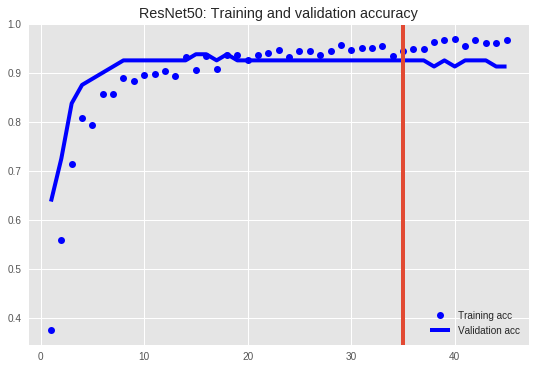

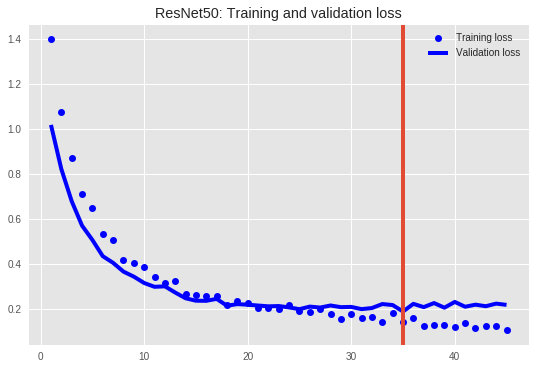

In [151]:
# Plotting error
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.style.use('ggplot')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.axvline(x=35)
plt.title('ResNet50: Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.axvline(x=35)
plt.title('ResNet50: Training and validation loss')
plt.legend()
plt.show()

I'll pick the model from epoch 35 as the model to use to predict the test set since it had the lowest validation loss.

### Load model and predict test set

In [0]:
from keras.models import load_model

# Load our model from epoch 35
custom_model = load_model('ResNet_models/ResNet_Transfer-35-0.19.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
# Validation data is not augmented
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Creating the validation generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

Found 664 images belonging to 1 classes.


In [0]:
result = custom_model.predict_generator(test_generator, steps = 664)

In [0]:
import pandas as pd

# Get filenames and predictions
filenames = test_generator.filenames
predictions = [np.argmax(each) for each in result]

In [0]:
# Convert predictions
idx2label = {y:x for x,y in train_generator.class_indices.items()}
prediction_labels = [idx2label[i] for i in predictions]

# Actual
filenames_formatted = [each.split('/')[1] for each in filenames]

# Result
result = pd.DataFrame({'file':filenames_formatted,
                       'category':prediction_labels})

# Reorder columns
result = result[['file', 'category']]

In [152]:
# Get a snapshot
result.head()

,file,category
0,ANd9GcQ-6pQo9fg5S5QMcV8N8J54yYqrubYCWw-bq4-Da1...,sunsets
1,ANd9GcQ-9q7fjHdCPVLZHzTvLPvtklacP7xAO82eCTM2Eu...,rivers
2,ANd9GcQ-HRsM6J42Mc2BJaSFXbxIidQEep8bjhaHdn-xUC...,cloudy_sky
3,ANd9GcQ-LMF6HugDQXa53SIoj6Vy-hc27j4ZGBnzYwO4gs...,sunsets
4,ANd9GcQ-QkSjvhAO2PUo4kqHvKKshorQFRMekpYD06BGTt...,trees_and_forest


### Output to csv file:

In [0]:
result.to_csv('ResNet50_Transfer.csv', index=False)

## Result

Using this approach, the model correctly classified **94%** of the images  from the test-set upon submission to Kaggle. The best team in the competition managed 86% using traditional computer vision approaches. This is an 8% improvement and highlights how easy it is to use powerful neural networks even with small datasets. In this case, it was particularly easy because the images that were being classified were not too dissimilar to the image set the original model was trained on (ImageNet).  